<a href="https://colab.research.google.com/github/thant-san/cat-and-dogs-pj/blob/main/pj_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
%time

SystemError: ignored

In [46]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing import image
import numpy as np

In [47]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [48]:
test_dir='/content/gdrive/MyDrive/Brain_tumor/Testing'
train_dir='/content/gdrive/MyDrive/Brain_tumor/Training'

In [49]:
import tensorflow as tf
model= tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape = (100, 100, 3)),
        #tf.keras.layers.Dense(1000,activation=tf.nn.relu),#hidden
        #tf.keras.layers.Dense(500,activation=tf.nn.relu),
        tf.keras.layers.Dense(200,activation=tf.nn.relu),
        tf.keras.layers.Dense(20,activation=tf.nn.relu),
        tf.keras.layers.Dense(4,activation=tf.nn.softmax) # output layers
])

In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1.0/255.)
test_datagen=ImageDataGenerator(rescale=1.0/255.)

In [52]:
import os
os.listdir(train_dir)

['notumor', 'glioma', 'meningioma', 'pituitary']

In [ ]:
os.listdir(train_dir+'/glioma')

In [53]:
import cv2
image=cv2.imread(train_dir+'/glioma/'+'Tr-gl_1273.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

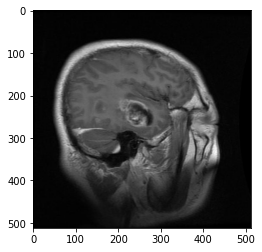

In [54]:
import matplotlib.pyplot as plt
plt.imshow(image)   

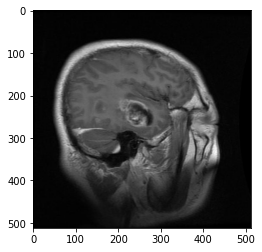

In [55]:
plt.imshow(image_rgb)

In [ ]:
import numpy as np
np.array(image_rgb.shape)

In [57]:
batch_size=20
training_set=train_datagen.flow_from_directory(train_dir,
                                               target_size=(100,100),
                                               batch_size=batch_size,
                                               class_mode='categorical')


Found 5712 images belonging to 4 classes.


In [ ]:
testing_set=test_datagen.flow_from_directory(test_dir,
                                             target_size=(100,100),
                                             batch_size=batch_size,
                                             class_mode='categorical')

In [ ]:
history=model.fit(training_set,
                  #validation_data = validation_set,
                              steps_per_epoch=5712//batch_size,
                        
                         epochs=20,
                         #validation_steps=validation_length//batch_size,
                         #validation_steps=2870//batch_size,
                         verbose = 2,
                         shuffle = False)

Epoch 1/20
285/285 - 32s - loss: 1.4169 - acc: 0.2800 - 32s/epoch - 112ms/step
Epoch 2/20
285/285 - 31s - loss: 1.3841 - acc: 0.2789 - 31s/epoch - 108ms/step
Epoch 3/20
285/285 - 31s - loss: 1.3837 - acc: 0.2791 - 31s/epoch - 110ms/step
Epoch 4/20
285/285 - 30s - loss: 1.3835 - acc: 0.2793 - 30s/epoch - 107ms/step
Epoch 5/20


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
#val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
#val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 
plt.plot  ( epochs,     acc ,label = 'Accuracy')
#plt.plot  ( epochs, val_acc)
#plt.title ('Training and validation accuracy')
plt.title ('Training Accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
#plt.plot  ( epochs, val_loss )
#plt.title ('Training and validation loss')
plt.title ('Training Loss')

plt.show()

In [ ]:
classes=model.predict(testing_set)

In [ ]:
folder_names=['glioma', 'pituitary', 'meningioma', 'no']
y_pred=[]
for folder in folder_names:
    path = test_dir+"/"+folder
    path_fnames = os.listdir(path)
    for i in path_fnames:
        path2 = path+'/'+i
        img = tf.keras.preprocessing.image.load_img(path2, target_size=(100,100))#target size ကို သတိထားပါ
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x,axis=0)
        x /= 255.0
        images = np.vstack([x])# [1 2 3 4 5 6]
        classes = model.predict(x)
        y_classes=classes.argmax(axis=-1)
        y_pred.append(y_classes[0])
    print()

In [ ]:
y_true = testing_set.classes.tolist()
print(len(y_true))

In [ ]:
class_dictionary = testing_set.class_indices
print('Labels dictionary',class_dictionary)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_true,y_pred)
print('confusion_matrix')
print(confusion_matrix)

In [ ]:
y_true

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print('Accuracy Score',accuracy_score(y_true, y_pred)*100,'%')
print('Precision Macro Score ',precision_score(y_true, y_pred,average = 'macro')*100,'%')
print('Recall_Score',recall_score(y_true, y_pred, average = 'macro')*100,'%')
print('F1_Score',f1_score(y_true, y_pred, average = 'macro')*100,'%')

In [ ]:
model.save('/neural_networks.h5')

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras import preprocessing
from tensorflow.keras.model import load_model
from tensorflow.keras.activation import softmax
import os
st.title("Brain tumer classification")
st.header("insert ur  mri file below")
def main():
     file_upload=st.file_uploader("choose the mri file",type=['jpg','png','jpeg'])
     image=Image.open(file_upload)
     figure=plt.figure()
     plt.imshow(image)
     plt.axis('off')
     result=predict_class(image)
     st.write(result)
     st.pyplot(figure)
def predict_class(image):
     classifier_model=tf.keras.models.load_model('cnn.h5')
     shape={(100,100,3)}
     tf.keras.Sequential(hub[hub.KerasLayer(classifier_model,input_shape=shape)])
     test_image=image.resize((128,128))
     test_image=preprocessing.image.img_to_array(test_image)
     test_image=test_image/255.0
     test_image=np.expand.dims(test_image,axis=0)
     class_names=['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor']

In [ ]:
!pip install pyngrok


In [ ]:
from pyngrok import ngrok

In [ ]:
!ngrok authtokenngrok config add-authtoken 28TNuZzTu6ykpMm7firbjHx2xPG_7Z2S7z9FFS1yRVeQd1ZhG

In [ ]:
!nohup streamlit run app.py &
url=ngrok.connect(port='8501')
print(url)